In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import datetime

### Класс для реализации KNN с окном Парзена (переменной ширины), в качестве ядра используется Гауссово ядро.

In [48]:
class ParzenKNN:
    def __init__(self, k=1):
        self.X_train = None
        self.y_train = None
        self.k = k  # кол-во соседей для определения ширины окна

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def euclidean_distances(self, x_test_i):
        # Рассчитываем евклидовы расстояния от одного объекта до всех обучающих.
        return np.sqrt(np.sum((self.X_train - x_test_i) ** 2, axis=1))

    @staticmethod
    def kernel(r):
        # Гауссово ядро: K(r) = (1 / sqrt(2*pi)) * exp(-0.5 * r^2)
        
        return (2 * np.pi) ** (-0.5) * np.exp(-0.5 * (r ** 2))

    def _make_prediction(self, x_test_i):
        # 1) Считаем все расстояния до данного тестового объекта
        distances = self.euclidean_distances(x_test_i)
        
        # 2) Сортируем индексы по возрастанию расстояний
        sorted_indices = np.argsort(distances)
        
        # 3) Определяем "ширину окна" h как расстояние (k+1)-го соседа
        #    Если k=1, то (k+1)-й = sorted_indices[1], то есть "второй" объект по близости.
        #    Дополнительно + 1e-4, чтобы избежать деления на 0.
        #    Если k=1 и всего 1 обучающий объект, нужна доп. проверка (но в Iris обычно 100+).
        h = distances[sorted_indices[self.k]] + 1e-4  # (k+1)-й сосед

        # 4) Считаем веса для всех объектов из обучающей выборки, используя Гауссово ядро
        weights = {}
        for idx in range(len(self.X_train)):
            cl = self.y_train[idx]
            r = distances[idx] / h  # отношение расстояния к ширине окна
            w = self.kernel(r)
            # аккумулируем вес для каждого класса
            if cl not in weights:
                weights[cl] = 0
            weights[cl] += w

        # 5) Выбираем класс с максимальной суммой весов
        return max(weights, key=weights.get)

    def predict(self, X_test):
        # Предсказание для набора объектов
        
        X_test = np.array(X_test)
        preds = []
        for x in X_test:
            preds.append(self._make_prediction(x))
        return pd.Series(preds)

  ### Подбор гиперпараметра k методом LOO (Leave-One-Out).

In [49]:
class LeaveOneOutSearch:

    def __init__(self, model_, k_max):
        self.model = model_
        self.k_max = k_max
        self.sum_s = {}
        self.best_param_ = None

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Перебираем все k от 1 до k_max
        for k_ in range(1, self.k_max + 1):
            errors = 0
            self.model.k = k_

            # LOO: на каждой итерации исключаем ровно 1 объект из train
            for i in range(len(X_train)):
                # создаём тест. объект
                x_test = X_train[i].reshape(1, -1)
                y_test = y_train[i]

                # создаём train без объекта i
                X_train_loo = np.concatenate([X_train[:i], X_train[i+1:]])
                y_train_loo = np.concatenate([y_train[:i], y_train[i+1:]])

                # обучаем модель
                self.model.fit(X_train_loo, y_train_loo)
                # делаем предсказание (возвращается Series)
                y_pred = self.model.predict(x_test)

                # сравниваем
                if y_pred.iloc[0] != y_test:
                    errors += 1

            # доля ошибок
            self.sum_s[k_] = errors / len(X_train)

        # ищем k с наименьшей ошибкой
        min_error = min(self.sum_s.values())
        # если таких k несколько, берём первый
        for k_, err in self.sum_s.items():
            if err == min_error:
                self.best_param_ = k_
                break

### Загрузка данных. Подбор kk методом LOO. Сравнение метрик. Графическая визуализация

Лучшее значение k (собственный алгоритм): 1
Время работы собственного алгоритма (мс): 429924
Accuracy (собственный алгоритм): 98.33
Precision (собственный алгоритм): 98.55
Recall (собственный алгоритм): 98.04
F1-score (собственный алгоритм): 98.25


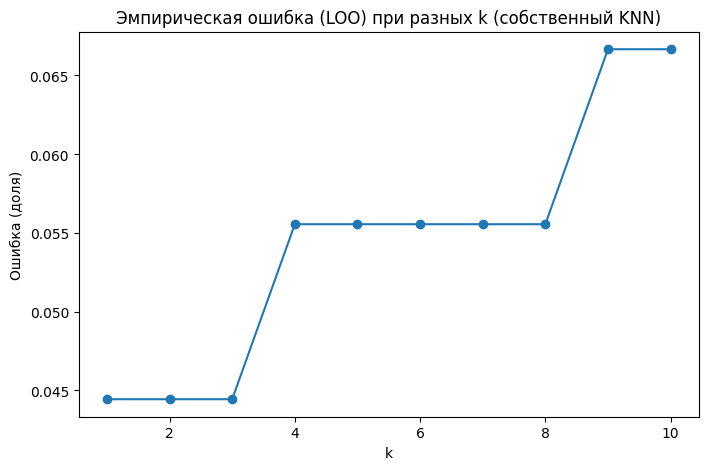

Лучшее значение k (библиотечный алгоритм): 5
Время работы библиотечного алгоритма (мс): 396450
Accuracy (библиотечный алгоритм): 96.67
Precision (библиотечный алгоритм): 97.22
Recall (библиотечный алгоритм): 96.08
F1-score (библиотечный алгоритм): 96.47


In [54]:
def main():
    # Загрузка и подготовка данных
    data = pd.read_csv("iris.csv")
    features = data.drop(['species'], axis=1)
    target = data['species']

    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.4, random_state=24
    )

   
    # Подбор k методом LOO и обучение собственной реализацией
    start_time_custom = datetime.datetime.now()
    # Создаём модель, в которую будем подставлять k
    custom_knn = ParzenKNN(k=1)
    # Ищем лучший k от 1 до 10
    search_params = LeaveOneOutSearch(model_=custom_knn, k_max=10)
    search_params.fit(features_train, target_train)
    best_k = search_params.best_param_
    print(f"Лучшее значение k (собственный алгоритм): {best_k}")

    # Обучаем модель с найденным k на полном train
    custom_knn = ParzenKNN(k=best_k)
    custom_knn.fit(features_train, target_train)

    # Предсказываем на test
    target_pred = custom_knn.predict(features_test)

    end_time_custom = datetime.datetime.now()
    time_hand = end_time_custom - start_time_custom
    print(f"Время работы собственного алгоритма (мс): {time_hand.microseconds}")

    # Accuracy
    compare_df = pd.DataFrame({'y_pred': list(target_pred), 'y_true': list(target_test)})
    acc_custom = (compare_df['y_true'] == compare_df['y_pred']).mean()
    print(f"Accuracy (собственный алгоритм): {acc_custom * 100:.2f}")

    # Подсчёт precision, recall, F1 по классам
    classes = sorted(target.unique())  # ['setosa', 'versicolor', 'virginica']
    TP, FP, FN, TN = [], [], [], []
    for metric in classes:
        TP.append(len(compare_df[(compare_df['y_true'] == metric) & (compare_df['y_pred'] == metric)]))
        FP.append(len(compare_df[(compare_df['y_true'] != metric) & (compare_df['y_pred'] == metric)]))
        FN.append(len(compare_df[(compare_df['y_true'] == metric) & (compare_df['y_pred'] != metric)]))
        TN.append(len(compare_df[(compare_df['y_true'] != metric) & (compare_df['y_pred'] != metric)]))

    TP = np.array(TP)
    FP = np.array(FP)
    FN = np.array(FN)
    TN = np.array(TN)

    prec = TP / (TP + FP + 1e-9)
    rec = TP / (TP + FN + 1e-9)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-9)

    print(f"Precision (собственный алгоритм): {prec.mean() * 100:.2f}")
    print(f"Recall (собственный алгоритм): {rec.mean() * 100:.2f}")
    print(f"F1-score (собственный алгоритм): {f1.mean() * 100:.2f}")

    # Построение графика эмпирической ошибки при разных k
    plt.figure(figsize=(8, 5))
    plt.plot(list(search_params.sum_s.keys()), list(search_params.sum_s.values()), marker='o')
    plt.title("Эмпирическая ошибка (LOO) при разных k (собственный KNN)")
    plt.xlabel("k")
    plt.ylabel("Ошибка (доля)")
    plt.show()

    # Сравнение с библиотечной реализацией KNN
    start_time_sklearn = datetime.datetime.now()
    clf = GridSearchCV(
        KNeighborsClassifier(), 
        {'n_neighbors': range(1, 10)},
        cv=5
    )
    clf.fit(features_train, target_train)
    best_model = KNeighborsClassifier(**clf.best_params_)
    best_model.fit(features_train, target_train)
    predicted = best_model.predict(features_test)

    end_time_sklearn = datetime.datetime.now()
    time_lib = end_time_sklearn - start_time_sklearn
    print(f"Лучшее значение k (библиотечный алгоритм): {clf.best_params_['n_neighbors']}")
    print(f"Время работы библиотечного алгоритма (мс): {time_lib.microseconds}")

    # Accuracy
    compare_df_lib = pd.DataFrame({'y_pred': list(predicted), 'y_true': list(target_test)})
    acc_lib = (compare_df_lib['y_true'] == compare_df_lib['y_pred']).mean()
    print(f"Accuracy (библиотечный алгоритм): {acc_lib * 100:.2f}")

    # Метрики
    TP_lib, FP_lib, FN_lib, TN_lib = [], [], [], []
    for metric in classes:
        TP_lib.append(len(compare_df_lib[(compare_df_lib['y_true'] == metric) & (compare_df_lib['y_pred'] == metric)]))
        FP_lib.append(len(compare_df_lib[(compare_df_lib['y_true'] != metric) & (compare_df_lib['y_pred'] == metric)]))
        FN_lib.append(len(compare_df_lib[(compare_df_lib['y_true'] == metric) & (compare_df_lib['y_pred'] != metric)]))
        TN_lib.append(len(compare_df_lib[(compare_df_lib['y_true'] != metric) & (compare_df_lib['y_pred'] != metric)]))

    TP_lib = np.array(TP_lib)
    FP_lib = np.array(FP_lib)
    FN_lib = np.array(FN_lib)
    TN_lib = np.array(TN_lib)

    prec_lib = TP_lib / (TP_lib + FP_lib + 1e-9)
    rec_lib = TP_lib / (TP_lib + FN_lib + 1e-9)
    f1_lib = 2 * (prec_lib * rec_lib) / (prec_lib + rec_lib + 1e-9)

    print(f"Precision (библиотечный алгоритм): {prec_lib.mean() * 100:.2f}")
    print(f"Recall (библиотечный алгоритм): {rec_lib.mean() * 100:.2f}")
    print(f"F1-score (библиотечный алгоритм): {f1_lib.mean() * 100:.2f}")

if __name__ == "__main__":
    main()